In [1]:
import os, shutil
from os.path import join as joinpath
from os import listdir

In [2]:
"""
# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.
datadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/resisc45"
imagedir = joinpath(datadir, "images")
resultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"

# path to metadata file with at least 2 columns: filename and label
metadata_filepath = joinpath(datadir, "resisc45-filtered-metadata.csv")
# names of these 2 columns
labelcolumn = "category"
filecolumn = "filename"

# result are saved in this folder inside the resultdir
dataname = "mini_resisc"
# prefix for output file
resultprefix = "mini_resisc-reptile-nopretrain"

random_seed = 2021
"""

'\n# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.\ndatadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/resisc45"\nimagedir = joinpath(datadir, "images")\nresultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"\n\n# path to metadata file with at least 2 columns: filename and label\nmetadata_filepath = joinpath(datadir, "resisc45-filtered-metadata.csv")\n# names of these 2 columns\nlabelcolumn = "category"\nfilecolumn = "filename"\n\n# result are saved in this folder inside the resultdir\ndataname = "mini_resisc"\n# prefix for output file\nresultprefix = "mini_resisc-reptile-nopretrain"\n\nrandom_seed = 2021\n'

In [3]:
# Expected input format: an `images` folder with all images in flat structure, i.e. as direct children.
datadir = "/mnt/beegfs/home/vu/Codalab-MetaDL/data/mini-imagenet/formatted-mini-imagenet"
imagedir = joinpath(datadir, "images")
resultdir = "/mnt/beegfs/home/vu/Codalab-MetaDL/result"

# path to metadata file with at least 2 columns: filename and label
metadata_filepath = joinpath(datadir, "labels.csv")
# names of these 2 columns
labelcolumn = "labelname"
filecolumn = "file"

# result are saved in this folder inside the resultdir
dataname = "mini_imagenet"
# prefix for output file
resultprefix = "mini_imagenet-reptile-nopretrain"

random_seed = 2021

In [4]:
figdir = joinpath(resultdir, dataname, resultprefix, 'fig')
modeldir = joinpath(resultdir, dataname, resultprefix, 'model')
metricdir = joinpath(resultdir, dataname, resultprefix, 'metric')

for outputdir in (figdir, modeldir, metricdir):
    os.makedirs(outputdir, exist_ok=True)

In [5]:
# import os, shutil
# from os.path import join as joinpath

from pathlib import Path

import sys, copy
import itertools, math

from functools import partial
import json

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm_notebook as tqdm
# from tqdm.autonotebook import tqdm
# from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics

import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.autograd as autograd

import captum.attr
import scipy

In [6]:
pd.options.mode.chained_assignment = None 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 600,
}
plt.rcParams.update(pltparams)

sns.set(font_scale = 1.2)

## Load data

In [7]:
filtered_metadata = pd.read_csv(metadata_filepath, index_col=0)
filtered_frequency = filtered_metadata.value_counts(labelcolumn)
filtered_metadata.sample(5)

,file,labelcode,labelname,metapartition
5479,5479.jpg,n02091831,Saluki,train
57716,57716.jpg,n04149813,scoreboard,test
20464,20464.jpg,n03476684,hair_slide,train
53441,53441.jpg,n02871525,bookshop,test
6157,6157.jpg,n02101006,Gordon_setter,train


Text(0.5, 0.98, 'mini_imagenet')

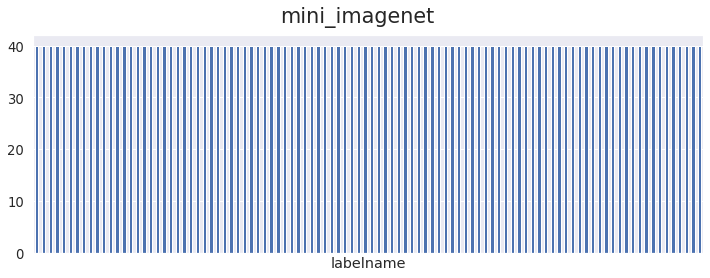

In [8]:
plt.figure(figsize=(12, 4))
ax = filtered_frequency.plot(kind="bar")
ax.set_xticks([])
plt.suptitle(dataname)

# ax.figure.savefig(joinpath(figdir, f'{dataname}-distribution.png'), bbox_inches='tight')

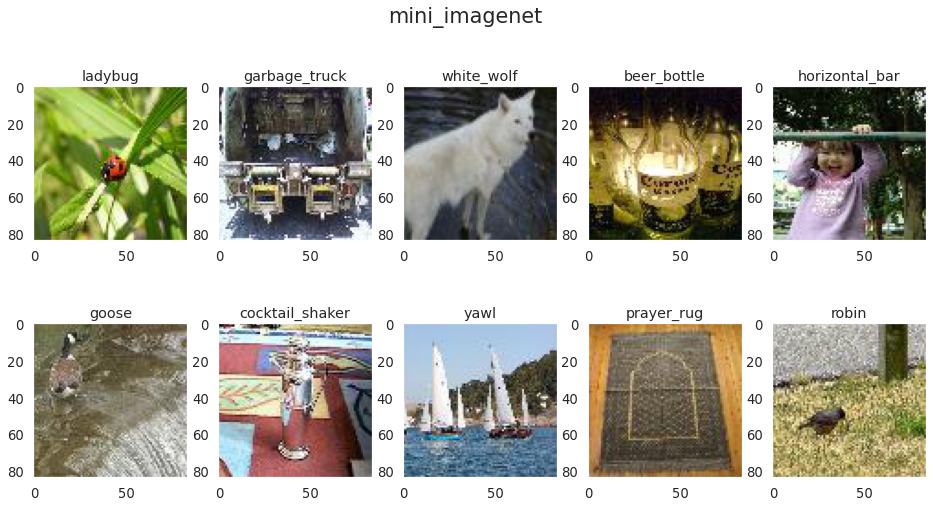

In [9]:
def tensor_to_display(imagetensor):
    return imagetensor.numpy().transpose((1, 2, 0))

def show_images(metadata, imagedir, rows=2, columns=5, figsize=(16, 8), title=None):
    sns.set_style("dark")

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.flatten()
    
    for index, ax in enumerate(axes):
        imageinfo = metadata.iloc[index]
        image = PIL.Image.open(joinpath(imagedir, imageinfo[filecolumn]))
        width, height = image.size
#         print(width,height)
        ax.imshow(image)
        ax.set_title(imageinfo[labelcolumn])
#         plt.axis('off')

    if title is not None:
        plt.suptitle(title)
    
    return fig

fig = show_images(filtered_metadata.sample(10), imagedir, title=dataname)

# fig.savefig(joinpath(basedir, 'fig', f'{dataname}-sample-image.png'))


## Few shot setting

In [10]:
def meta_train_test_split(frequency, test_fraction=0.25, randomseed=None):
    """
    Shuffle the labels, then split
    """
    np.random.seed(randomseed)
    shuffled_index = np.random.permutation(frequency.index)
    
    split_index = int((1 - test_fraction) * len(frequency))
    metatrain_classes = shuffled_index[:split_index]
    metatest_classes = shuffled_index[split_index:]
    
    return metatrain_classes, metatest_classes

metatrain_classes, metatest_classes = meta_train_test_split(filtered_frequency, randomseed=random_seed)
# print(metatrain_classes, metatest_classes)
# print(len(metatrain_classes), len(metatest_classes))

In [11]:
def train_valid_split(metadata, kshot, randomseed=None):
    """
    support and query split for each label
    """
    
    traindata = metadata.groupby(labelcolumn).sample(kshot, random_state=randomseed)
    traindata['partition'] = "train"

    valid_index = metadata.index.difference(traindata.index)
    validdata = metadata.loc[valid_index, :]
    validdata['partition'] = "valid"

    return pd.concat((traindata, validdata))

# train_valid_split(filtered_metadata, 20, random_seed)

In [12]:
test_params = {
    'nway': 5,
    'kshot': 5,
    # inner loop parameters
    'inner_lr': 1e-4,
    'inner_batchsize': 64,
    'update_count': 5,
    # outter loop parameters
    'meta_lr': 1e-2,
    'meta_iteration': 2,
    'learn_task_per_iteration': 4,
    # assessment
    'assess_frequency': 1,
    'assess_task_per_iteration': 4,
}


In [13]:
class SupportQueryGenerator:
    def __init__(self, metadata, all_classes, params):
        self.metadata, self.all_classes, self.params = metadata, all_classes, params
        self.labelindex = {label:index for index, label in enumerate(all_classes)}
        self.taskset = set()
        self.duplicate_count = 0
        self.max_duplicate_count = max(100, params['meta_iteration'])
        
    def next(self):
        sampled_labels = np.random.choice(self.all_classes, self.params['nway'], replace=False)
        sorted_indexed_labels = sorted([str(self.labelindex[label]) for label in sampled_labels])
        taskkey = ' '.join(sorted_indexed_labels)
        
        while self.duplicate_count < self.max_duplicate_count:
            if taskkey in self.taskset:
                self.duplicate_count += 1
                return
            else:
                self.taskset.add(taskkey)

                support = self.metadata[(self.metadata[labelcolumn].isin(sampled_labels)) & (self.metadata.partition == "train")]
                query = self.metadata[(self.metadata[labelcolumn].isin(sampled_labels)) & (self.metadata.partition == "valid")]

                labelcode = LabelEncoder()
                query["labelcode"] = labelcode.fit_transform(query[labelcolumn])
                support["labelcode"] = labelcode.transform(support[labelcolumn])

                return support, query, labelcode

In [14]:
def train_transform(pil_image, imagesize):
    width, height = pil_image.size
    transform = transforms.Compose([
        transforms.CenterCrop(min(width, height)),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
#         transforms.Resize(imagesize),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(pil_image)

def test_transform(pil_image, imagesize):
    transform = transforms.Compose([
        transforms.Resize(imagesize),
        transforms.ToTensor(),
    ])
    return transform(pil_image)


In [15]:
class FewShotDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, imagedir, transform=None):
        self.metadata = metadata
        self.imagedir = imagedir
        self.transform = transform
    
    def __getitem__(self, index):
        imageinfo = self.metadata.iloc[index]
        
        imagedata = PIL.Image.open(os.path.join(self.imagedir, imageinfo[filecolumn])) 
        transformed_image = self.transform(imagedata) if self.transform else imagedata
        label = imageinfo["labelcode"]
#         print(transformed_image.shape)

        return transformed_image, label

    def __len__(self):
        return len(self.metadata)
    
def build_data(metadata, imagedir, batchsize, ifshuffle, transform=None):
    dataset = FewShotDataset(metadata, imagedir, transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=ifshuffle)
    return dataset, dataloader


In [16]:
def preprocess_metadata(metadata, random_seed=None):
    processed_metadata, labelcode = encode_label(metadata)
    train_metadata, valid_metadata = train_test_split(processed_metadata, test_size=0.5, stratify=processed_metadata[labelcolumn], random_state=random_seed)
#     print(train_metadata.shape, valid_metadata.shape)

    numberclass = valid_metadata["labelcode"].max() + 1
    labelnames = labelcode.inverse_transform(range(numberclass))
    
    return train_metadata, valid_metadata, labelcode, numberclass, labelnames


In [17]:
def display_tensor(dataloader, labelcode):
    inputs, labels = next(iter(dataloader))
    print(inputs.shape, labels.shape)
    for inpt, label in zip(inputs[:4], labels[:4]):
        plt.figure()
        plt.imshow(tensor_to_display(inpt))
        plt.title(labelcode.inverse_transform([label]))


In [18]:
imagesize=(128, 128)
transform0 = partial(train_transform, imagesize=(imagesize))
test_generator = SupportQueryGenerator(train_valid_split(filtered_metadata, 20, random_seed), 
    metatrain_classes, test_params)

torch.Size([5, 3, 84, 84]) torch.Size([5])


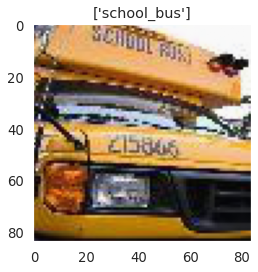

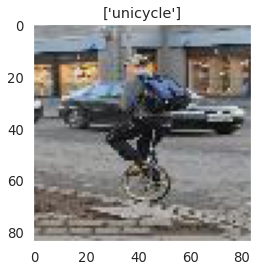

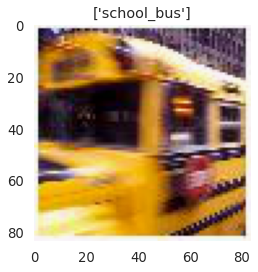

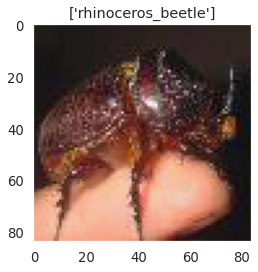

In [19]:
support, query, labelcode = test_generator.next()
dataset, dataloader = build_data(query, imagedir, 5, True, transform0)
display_tensor(dataloader, labelcode)

In [20]:
# iterator = iter(dataloader)

In [21]:
# for i in range(3):
#     print(next(iterator)[1])

In [22]:
# iterator = iter(dataloader)

In [23]:
# for i in range(3):
#     print(next(iterator)[1])

## Model

In [24]:
def get_model_resnet_dropout(outsize, with_pretrained=True, with_dropout=True):
    model = models.resnet18(pretrained=with_pretrained)

    if with_dropout:
        drop_proba = dict(layer4=0.1, layer3=0.1)

        for layer, sublayer, module in itertools.product(drop_proba.keys(), [0, 1], "conv1 conv2".split()):
            modulename = f"""model.{layer}[{sublayer}].{module}"""
            command = f"""{modulename} = nn.Sequential(nn.Dropout({drop_proba[layer]}), {modulename})"""
    #         print(command)
            exec(command)

        for layer, proba in drop_proba.items():
            command = f"""conv_outchannels = model.{layer}[0].conv2[1].out_channels"""
            exec(command)
            modulename = f"""model.{layer}[0].bn2"""
            command = f"""{modulename} = nn.Sequential(nn.Dropout(proba), {modulename})"""
            exec(command)    

    conv_outsize = model.fc.in_features
    model.fc = nn.Linear(conv_outsize, outsize)

    return model.to(device)

def clone_model(model):
    return copy.deepcopy(model).to(device)   

## Define training

In [25]:
def get_optim_param_dict_resnet(model, lrrange):
    """
    Geometric progression of learning rate per layer block
    """
    paramgroups = {}
    namegroup = {}
    
    for name, param in model.named_parameters():
#         print(name)
        groupname = '.'.join(name.split('.')[:2])
        
        if groupname.startswith("fc"):
            groupname = "fc"
        
        layergroup = namegroup.setdefault(groupname, [])
        layergroup.append(name)
        namegroup[groupname] = layergroup
    
        paramgroup = paramgroups.setdefault(groupname, [])
        paramgroup.append(param)
        paramgroups[groupname] = paramgroup
    
    lrgroup = np.geomspace(*lrrange, num=len(paramgroups))
    optim_param = [dict(params=group, lr=lr, weight_decay=1) for group, lr in zip(paramgroups.values(), lrgroup)]

    return optim_param

def get_lrrange_optimizer(model, lrrange, get_paramdict_func):
    optim = torch.optim.SGD(get_paramdict_func(model, lrrange), lr=lrrange[-1])
#     task_optim = torch.optim.Adam(task_model.parameters(), lr=params['inner_lr'], betas=(0, 0))
    
    return optim

In [26]:
def init_task_model_optim(meta_model, params):
    task_model = clone_model(meta_model).train()
#     task_optim = torch.optim.Adam(task_model.parameters(), lr=params['inner_lr'], betas=(0, 0))
    task_optim = torch.optim.SGD(task_model.parameters(), lr=params['inner_lr'], weight_decay=1)
#     task_optim = get_lrrange_optimizer(task_model, (1e-6, params['inner_lr']), get_optim_param_dict_resnet)

    return task_model, task_optim

In [27]:
def update_model(lossfunc, optim, model, xbatch, ybatch):
    optim.zero_grad()
    loss = lossfunc(model(xbatch.to(device)), ybatch.to(device))
    loss.backward()
    optim.step()
    
    return loss

def compute_task_gradient(meta_model, task_model):
    # record weights
    for oldparams, newparams in zip(meta_model.parameters(), task_model.parameters()):
        if oldparams.grad is None:
            oldparams.grad = autograd.Variable(torch.zeros_like(oldparams)).to(device)
        # invert loss eqn. to use descent optimization
        oldparams.grad.data.add_(oldparams.data - newparams.data)
#         oldparams.grad.data.add_(newparams.grad.data)


In [28]:
def score_predictions(predictions, targets):
    score = sklearn.metrics.accuracy_score(targets, predictions)
    return score

def one_batch(model, inputs, labels, lossfunc, device, optim=None):
    if optim: optim.zero_grad()
        
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = lossfunc(outputs, labels)
    
    predictions = torch.argmax(outputs, dim=1)  

    if optim:
        loss.backward()
        optim.step()

    return loss, predictions, labels


In [29]:

def init_result():
    result = dict(loss=0., predictions=[], labels=[], samplecount=0.)
    return result

def update_result(result, loss, predictions, labels):
    result['loss'] += loss.item()
    result['predictions'].append(predictions)
    result['labels'].append(labels)
    result['samplecount'] += len(labels)
    
    return result

def get_metric(result):
    result['predictions'] = torch.cat(result['predictions'])
    result['labels'] = torch.cat(result['labels'])
    
    metric = dict(
        loss = result['loss'] / result['samplecount'],
        score = score_predictions(result['predictions'].detach().cpu(), result['labels'].detach().cpu())
    )
    
    return metric

In [30]:
class BatchIterator():
    def __init__(self, metadata, imagedir, batchsize, ifshuffle, transform):
        self.metadata, self.imagedir, self.batchsize, self.ifshuffle, self.transform = metadata, imagedir, batchsize, ifshuffle, transform
        self.dataset, self.dataloader = build_data(
            self.metadata, self.imagedir, self.batchsize, self.ifshuffle, self.transform
        )
        self.data_iterator = iter(self.dataloader)

    def next_batch(self):
        try:
            return next(self.data_iterator)
        
        except StopIteration as exception:
#             self.dataset, self.dataloader = build_data(
#                 self.metadata, self.imagedir, self.batchsize, self.ifshuffle, self.transform
#             )
            self.data_iterator = iter(self.dataloader)
#             print('Exception, rebuild dataloader')
            
            return next(self.data_iterator)


In [31]:
def train_evaluate_episode(params, meta_model, lossfunc, support_metadata, query_metadata, 
    imagedir, train_transform, test_transform):
    
    task_model, task_optim = init_task_model_optim(meta_model, params)
    
    # train on batches of the dataset
    stepcount = 0
    support_result = init_result()
    support_batch_iterator = BatchIterator(support_metadata, imagedir, 
        batchsize=params["inner_batchsize"], ifshuffle=True, transform=train_transform)
#     support_dataset, support_dataloader = build_data(support_metadata, imagedir, 
#         batchsize=params["inner_batchsize"], ifshuffle=True, transform=train_transform)
    
    while (stepcount < params["update_count"]) :
        xbatch, ybatch = support_batch_iterator.next_batch()
#         xbatch, ybatch = next(iter(support_dataloader))
        loss, predictions, labels = one_batch(task_model, xbatch, ybatch, lossfunc, device, optim=task_optim)
        support_result = update_result(support_result, loss, predictions, labels)
        stepcount += 1
        if stepcount == params["update_count"]: 
#             print(f"{stepcount = }")
            break

    support_metric = get_metric(support_result)

    # evaluate with episode query
    query_result = init_result()
    query_dataset, query_dataloader = build_data(query_metadata, imagedir, 
        batchsize=params["inner_batchsize"], ifshuffle=False, transform=test_transform)
    
    for (xbatch, ybatch) in (query_dataloader):
        loss, predictions, labels = one_batch(task_model, xbatch, ybatch, lossfunc, device, optim=None)
        query_result = update_result(query_result, loss, predictions, labels)
    
    query_metric = get_metric(query_result)

    return task_model, support_metric, query_metric


In [32]:
def init_assessment_record(filepath, nway):
    if os.path.exists(filepath): os.remove(filepath)
    headers = "assess_iteration," + \
    ",".join([f"label_{i}" for i in range(1, nway+1)]) + \
    ",supportloss,supportscore,queryloss,queryscore" + \
    "\n"
    
    with open(filepath, 'a') as file:
        file.write(headers)
    
    return
        
def record_assessment(task_labelcode, assess_iteration, support_metric, query_metric, filepath):
#     assess_record = ", ".join(task_labelcode.classes_) + f", {metric['score']:.4f}, {assess_iteration}" + "\n"
    assess_record = f"{assess_iteration}," + \
    ",".join(task_labelcode.classes_) + \
    f",{support_metric['loss']},{support_metric['score']}" + \
    f",{query_metric['loss']},{query_metric['score']}" + \
    "\n"

    with open(filepath, 'a') as file:
        file.write(assess_record)

    return 


In [33]:
def one_meta_iteration(support_query_generator, params, meta_model, lossfunc, imagedir,
    train_transform, test_transform, assess_iteration, assess_path, is_learning):
    
    task_count = 1;
    max_taskcount = params["learn_task_per_iteration"] if is_learning else params["assess_task_per_iteration"]    
    
    # inner train loop, learn task      
    
    while (task_count <= max_taskcount):
        try:
            support_metadata, query_metadata, task_labelcode = support_query_generator.next()

            task_model, support_metric, query_metric = train_evaluate_episode(params, meta_model, lossfunc, 
                support_metadata, query_metadata, imagedir, train_transform, test_transform)

            if is_learning:
                compute_task_gradient(meta_model, task_model)
            else:
    #             print(task_labelcode.classes_)
                print("support", support_metric, "\nquery", query_metric, '\n')
                record_assessment(task_labelcode, assess_iteration, support_metric, query_metric, assess_path)

            task_count += 1
        except TypeError as exception:
            print(exception)
    return


In [34]:
def updata_meta_model(meta_model, meta_optim, params):
    for metaparams in meta_model.parameters():
        metaparams.grad.data.div_(params['learn_task_per_iteration'])
        meta_optim.step()
    
    return

In [35]:
def save_checkpoint(model, optimizer, savepath):
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, savepath)
    return savepath

def load_checkpoint(loadpath, model, optimizer):
    checkpoint = torch.load(loadpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

def save_params(params, savepath):
#     params['current_iteration'] = current_iteration
    with open(savepath, 'w') as file:
        json.dump(params, file)
    return savepath
    
def load_params(loadpath):
    with open(loadpath) as file:
        params = json.load(file)
        
    return params

In [36]:
#https://github.com/gebob19/REPTILE-Metalearning/blob/master/omniglot_trainer.ipynb

def train_reptile(params, meta_optim, meta_model, lossfunc, metatrain_classes, metatest_classes,
    metadata, imagedir, train_transform, test_transform, assess_path, checkpoint_path):  
    
    init_assessment_record(assess_path, params['nway'])
    assess_iteration = 0
    metatrain_generator = SupportQueryGenerator(metadata, metatrain_classes, params)
    metatest_generator = SupportQueryGenerator(metadata, metatest_classes, params)

    # outer meta loop
    for meta_iteration in range(1, params['meta_iteration']+1):

        meta_optim.zero_grad()
        
        one_meta_iteration(metatrain_generator, params, meta_model, lossfunc, imagedir,
            train_transform, test_transform, assess_iteration, assess_path, is_learning=True)
                
        # update metamodel with avg over mini batches 
        updata_meta_model(meta_model, meta_optim, params)
            
        # metatest validation episodes
        assess_records = [];
        
        if (meta_iteration % params['assess_frequency']) == 0 :
            print(f"\n{meta_iteration = }", '=' * 20)
            assess_iteration += 1
            
            one_meta_iteration(metatest_generator, params, meta_model, lossfunc, imagedir,
                train_transform, test_transform, assess_iteration, assess_path, is_learning=False)
        
            savepath = save_checkpoint(meta_model, meta_optim, checkpoint_path)
    # end meta epoch loop
    savepath = save_checkpoint(meta_model, meta_optim, checkpoint_path)
    return

## Run Training

In [37]:
way5_shot20_params = {
    'nway': 5,
    'kshot': 5,
    # inner loop parameters
    'inner_lr': 1e-4,
    'inner_batchsize': 64,
    'update_count': 5,
    # outter loop parameters
    'meta_lr': 1e-1,
    'meta_iteration': 10,
    'learn_task_per_iteration': 8,
    # assessment
    'assess_frequency': 1,
    'assess_task_per_iteration': 4,
}

params = way5_shot20_params
params['current_iteration'] = params['meta_iteration']

In [38]:
if 'imagenet' in dataname:
    metatrain_classes = filtered_metadata[filtered_metadata['metapartition'] == 'train'][labelcolumn].unique()
    metatest_classes = filtered_metadata[filtered_metadata['metapartition'] == 'valid'][labelcolumn].unique()
else:
    metatrain_classes, metatest_classes = meta_train_test_split(filtered_frequency)
print(len(metatrain_classes), len(metatest_classes))
split_metadata = train_valid_split(filtered_metadata, params['kshot'], random_seed)

imagesize=(128, 128)
train_transform0 = partial(train_transform, imagesize=imagesize)
test_transform0 = partial(test_transform, imagesize=imagesize)


64 16


In [39]:
meta_model = get_model_resnet_dropout(params['nway'], with_pretrained=False, with_dropout=False)
meta_optim = torch.optim.SGD(meta_model.parameters(), lr=params['meta_lr'])
lossfunc = nn.CrossEntropyLoss(reduction='sum')

model_name = resultprefix + '-resnet18-way{}-shot{}-learntask8'.format(params['nway'], params['kshot'])
assess_path = joinpath(metricdir, resultprefix + "-assessment.csv")         
checkpoint_path = joinpath(modeldir, model_name + ".pth")

params_path = joinpath(modeldir, "params.json")

print(params)

{'nway': 5, 'kshot': 5, 'inner_lr': 0.0001, 'inner_batchsize': 64, 'update_count': 5, 'meta_lr': 0.1, 'meta_iteration': 10, 'learn_task_per_iteration': 8, 'assess_frequency': 1, 'assess_task_per_iteration': 4, 'current_iteration': 10}


In [40]:
def load_checkpoint_params_if_exist(metamodel, metaoptim, checkpoint_path, params, params_path):
    if os.path.exists(checkpoint_path):
        metamodel, metatoptim = load_checkpoint(checkpoint_path, metamodel, metaoptim)
        
    if os.path.exists(params_path):
        loadedparams = load_params(params_path)
        params['current_iteration'] = loadedparams['current_iteration'] + params['meta_iteration']
        
    return metamodel, metaoptim, params


# meta_model, meta_optim, params = load_checkpoint_params_if_exist(meta_model, meta_optim, checkpoint_path, params, params_path)

In [41]:
train_reptile(params, meta_optim, meta_model, lossfunc, metatrain_classes, metatest_classes, 
    split_metadata, imagedir, train_transform0, test_transform0, assess_path, checkpoint_path)


/mnt/beegfs/home/vu/miniconda3/envs/py3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



meta_iteration = 1 ====================
support {'loss': 13.42632861328125, 'score': 0.2} 
query {'loss': 11.991380528041296, 'score': 0.2} 

support {'loss': 13.53490966796875, 'score': 0.2} 
query {'loss': 11.808752790178572, 'score': 0.2} 

support {'loss': 13.773427490234376, 'score': 0.2} 
query {'loss': 11.929884905133928, 'score': 0.2} 

support {'loss': 13.056960693359375, 'score': 0.2} 
query {'loss': 11.655345023018974, 'score': 0.2} 


meta_iteration = 2 ====================
support {'loss': 16.06351184082031, 'score': 0.208} 
query {'loss': 17.738677280970983, 'score': 0.2} 

support {'loss': 15.628544799804688, 'score': 0.2} 
query {'loss': 28.964244035993303, 'score': 0.2} 

support {'loss': 15.96468359375, 'score': 0.208} 
query {'loss': 22.77975830078125, 'score': 0.2057142857142857} 

support {'loss': 16.83376721191406, 'score': 0.208} 
query {'loss': 28.493502720424107, 'score': 0.2} 


meta_iteration = 3 ====================
support {'loss': 9.13812823486328, 'score

In [42]:
savedparams_path = save_params(params, params_path)

## Metric summary

In [43]:
# assess_path = joinpath(metricdir, resultprefix + "-assessment.csv")         

assessment_metric = pd.read_csv(assess_path)
assessment_metric

,assess_iteration,label_1,label_2,label_3,label_4,label_5,supportloss,supportscore,queryloss,queryscore
0,1,Ibizan_hound,goose,miniskirt,missile,poncho,13.426329,0.200,11.991381,0.200000
1,1,Ibizan_hound,catamaran,coral_reef,garbage_truck,meerkat,13.534910,0.200,11.808753,0.200000
2,1,cannon,carton,goose,horizontal_bar,meerkat,13.773427,0.200,11.929885,0.200000
3,1,Ibizan_hound,cannon,carton,horizontal_bar,iPod,13.056961,0.200,11.655345,0.200000
4,2,cannon,carton,combination_lock,iPod,poncho,16.063512,0.208,17.738677,0.200000
5,2,cannon,catamaran,goose,miniskirt,white_wolf,15.628545,0.200,28.964244,0.200000
6,2,Ibizan_hound,carton,catamaran,rhinoceros_beetle,white_wolf,15.964684,0.208,22.779758,0.205714
7,2,combination_lock,horizontal_bar,meerkat,missile,rhinoceros_beetle,16.833767,0.208,28.493503,0.200000
8,3,Ibizan_hound,cannon,iPod,miniskirt,rhinoceros_beetle,9.138128,0.200,35.390781,0.200000
9,3,catamaran,combination_lock,garbage_truck,iPod,meerkat,43.320050,0.200,6.982625,0.200000


In [44]:
summary_assessment_metric = assessment_metric.groupby('assess_iteration').agg([np.mean, np.std])
summary_assessment_metric

supportloss             supportscore            queryloss  \
                         mean        std          mean       std       mean   
assess_iteration                                                              
1                   13.447907   0.298238         0.200  0.000000  11.846341   
2                   16.122627   0.509339         0.206  0.004000  24.494046   
3                   23.596226  19.688658         0.200  0.000000  22.362443   
4                   31.970220  17.693777         0.200  0.000000  37.376799   
5                   15.961798   8.097407         0.200  0.000000  22.032072   
6                    7.473137   3.981877         0.200  0.000000   9.461184   
7                   10.032513   4.686354         0.202  0.004000   7.108802   
8                    5.048219   4.106193         0.208  0.019596   4.124603   
9                    4.933100   1.249312         0.182  0.022978   3.361275   
10                   4.650059   1.627338         0.198  0.025612   3.331939   

                             queryscore            
                        std        mean       std  
assess_iteration                                   
1                  0.148221    0.200000  0.000000  
2                  5.308864    0.201429  0.002857  
3                 11.951527    0.198571  0.002857  
4                  9.882947    0.200000  0.000000  
5                  1.865526    0.200000  0.000000  
6                  2.033416    0.200000  0.000000  
7                  1.765464    0.197143  0.003299  
8                  1.545548    0.238571  0.079505  
9                  1.140102    0.221429  0.113749  
10                 0.485275    0.168571  0.121173

In [45]:
print(summary_assessment_metric)

                  supportloss             supportscore            queryloss  \
                         mean        std          mean       std       mean   
assess_iteration                                                              
1                   13.447907   0.298238         0.200  0.000000  11.846341   
2                   16.122627   0.509339         0.206  0.004000  24.494046   
3                   23.596226  19.688658         0.200  0.000000  22.362443   
4                   31.970220  17.693777         0.200  0.000000  37.376799   
5                   15.961798   8.097407         0.200  0.000000  22.032072   
6                    7.473137   3.981877         0.200  0.000000   9.461184   
7                   10.032513   4.686354         0.202  0.004000   7.108802   
8                    5.048219   4.106193         0.208  0.019596   4.124603   
9                    4.933100   1.249312         0.182  0.022978   3.361275   
10                   4.650059   1.627338         0.1